In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('poster')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

from statsmodels.stats.outliers_influence import variance_inflation_factor    
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

import statsmodels.formula.api as smf

import time
import itertools

In [32]:
columnDict = pd.read_csv('./columnDict.csv')
columnDict.replace({'2B':'doubles', '3B': 'triples'}, inplace=True)

In [33]:
df = pd.read_csv('./baseball/core/Teams.csv')

In [34]:
df.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

In [35]:
def clean(df):
    df = df[df["yearID"]>=1977]
    df.fillna(0, inplace=True)
    
    #df['winP'] = df.apply(lambda row : row['W']/(row['W']+row['L']), axis=1)
    
    df.rename(columns={'2B':'doubles', '3B': 'triples'}, inplace=True)
    
    df['singles'] = df['H'] - df['doubles'] - df['triples'] - df['HR']
    
    excl = ['R', 'SV', 'SHO', 'ERA', 'PPF', 'BPF', 'H', 'Rank', 'L', 'yearID'] #Drop due to complete subsets of other data
    
    df.drop(excl, axis=1, inplace=True)
    
    teamCount = df['teamID'].value_counts()
    teamCount.sort_index(inplace=True)
    
    teamCount = teamCount[teamCount >= 40]
    df = df[df['teamID'].isin(teamCount.index.values)]
    return df

In [36]:
cleaned = clean(df)

/Users/Braden/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Users/Braden/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/Braden/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Braden/anaconda/lib

In [37]:
quant = pd.DataFrame(cleaned.loc[:, ~(cleaned.dtypes == object)])

In [38]:
quant.head()

,G,Ghome,W,AB,doubles,triples,HR,BB,SO,SB,...,IPouts,HA,HRA,BBA,SOA,E,DP,FP,attendance,singles
1709,162,81.0,61,5534,218,20,139,537,876.0,82.0,...,4335,1581,169,701,915,175,127.0,0.972,872464.0,1027
1710,161,81.0,97,5494,231,25,148,560,945.0,90.0,...,4353,1414,124,494,737,106,189.0,0.983,1195769.0,1029
1711,161,80.0,97,5510,258,56,213,528,905.0,66.0,...,4284,1555,158,378,758,132,162.0,0.978,2074549.0,1024
1713,162,81.0,90,5633,254,52,192,559,666.0,42.0,...,4332,1557,136,516,842,159,125.0,0.974,1657135.0,1070
1714,162,81.0,81,5604,271,37,111,534,796.0,64.0,...,4404,1500,128,489,942,153,147.0,0.977,1439834.0,1070


In [42]:
equation = "+".join(str(x) for x in quant.drop('W',axis=1).columns)
model = smf.ols('W~'+equation, data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     339.2
Date:                Fri, 15 Dec 2017   Prob (F-statistic):               0.00
Time:                        16:08:37   Log-Likelihood:                -2553.6
No. Observations:                 920   AIC:                             5159.
Df Residuals:                     894   BIC:                             5285.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    527.2324    278.560      1.893      0.059     -19.475    1073.940
G              0.1591      0.127      1.252      0.211      -0.090       0.408
Ghome          0.2874      0.146      1.971      0.049       0.001       0.574
AB            -0.0813      0.005    -15.167      0.000      -0.092      -0.071
doubles        0.1248      0.007     18.034      0.000       0.111       0.138
triples        0.1613      0.016     10.302      0.000       0.131       0.192
HR             0.2165      0.007     32.255      0.000       0.203       0.230
BB             0.0189      0.002      7.666      0.000       0.014       0.024
SO             0.0037      0.002      2.354      0.019       0.001       0.007
SB             0.0284      0.005      5.861      0.000       0.019       0.038
CS            -0.0923      0.014     -6.470      0.000      -0.120      -0.064
HBP            0.0223      0.013      1.758      0.079      -0.003       0.047
SF            -0.0486      0.016     -2.990      0.003      -0.080      -0.017
RA            -0.0386      0.014     -2.689      0.007      -0.067      -0.010
ER            -0.0227      0.015     -1.515      0.130      -0.052       0.007
CG             0.0044      0.017      0.257      0.797      -0.029       0.038
IPouts         0.0857      0.007     13.062      0.000       0.073       0.099
HA            -0.0092      0.004     -2.214      0.027      -0.017      -0.001
HRA           -0.0091      0.009     -1.046      0.296      -0.026       0.008
BBA           -0.0136      0.003     -4.126      0.000      -0.020      -0.007
SOA           -0.0048      0.002     -3.009      0.003      -0.008      -0.002
E             -0.1163      0.046     -2.506      0.012      -0.207      -0.025
DP             0.0023      0.009      0.259      0.796      -0.015       0.020
FP          -539.4576    284.190     -1.898      0.058   -1097.216      18.301
attendance  4.778e-07   2.51e-07      1.905      0.057   -1.45e-08     9.7e-07
singles        0.1110      0.005     21.896      0.000       0.101       0.121
==============================================================================
Omnibus:                        3.240   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.160
Skew:                          -0.143   Prob(JB):                        0.206
Kurtosis:                       3.032   Cond. No.                     7.06e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
mean_squared_error(quant['W'], model.predict(quant.drop('W',axis=1)))

15.079692814831064

In [52]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    equation = "+".join(str(x) for x in list(feature_set))
    model = smf.ols('W~'+equation, data=quant).fit()
    mse = mean_squared_error(model.predict(quant[list(feature_set)]), quant['W'])
    return {"model":model, "R^2":model.rsquared, "Adj_R^2":model.rsquared_adj, "MSE": mse}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(quant.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    models.head()
    
    # Choose the model with the highest Adjusted R^2
    best_model = models.loc[models['Adj_R^2'].argmax()]
    toc = time.time()
    
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model


def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in quant.drop('W',axis=1).columns if p not in predictors]

    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest MSE
    best_model = models.loc[models['Adj_R^2'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [56]:
forward_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])
tic = time.time()
predictors = []
for i in range(1,len(quant.drop('W',axis=1).columns)+1):
    forward_subset_models.loc[i] = forward(predictors)
    predictors = forward_subset_models.loc[i]["model"].model.exog_names
    predictors = [p for p in predictors if p not in ['Intercept']]
    
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")

Processed  25 models on 1 predictors in 0.29436302185058594 seconds.
Total elapsed time: 0.3006711006164551 seconds.
Processed  24 models on 2 predictors in 0.18249106407165527 seconds.
Total elapsed time: 0.48888707160949707 seconds.
Processed  23 models on 3 predictors in 0.2644190788269043 seconds.
Total elapsed time: 0.7587490081787109 seconds.
Processed  22 models on 4 predictors in 0.2843301296234131 seconds.
Total elapsed time: 1.049558162689209 seconds.
Processed  21 models on 5 predictors in 0.30592989921569824 seconds.
Total elapsed time: 1.361246109008789 seconds.
Processed  20 models on 6 predictors in 0.3418869972229004 seconds.
Total elapsed time: 1.7090849876403809 seconds.
Processed  19 models on 7 predictors in 0.3712770938873291 seconds.
Total elapsed time: 2.0853822231292725 seconds.
Processed  18 models on 8 predictors in 0.35301804542541504 seconds.
Total elapsed time: 2.443430185317993 seconds.
Processed  17 models on 9 predictors in 0.36973094940185547 seconds.
T

In [57]:
bestForward = forward_subset_models.iloc[forward_subset_models['MSE'].argmin()-1]['model']
forward_subset_models.iloc[forward_subset_models['MSE'].argmin()-1]

R^2                                                 0.904621
Adj_R^2                                             0.901954
MSE                                                  15.0797
model      <statsmodels.regression.linear_model.Regressio...
Name: 25, dtype: object

In [70]:
bestForward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     339.2
Date:                Fri, 15 Dec 2017   Prob (F-statistic):               0.00
Time:                        16:17:25   Log-Likelihood:                -2553.6
No. Observations:                 920   AIC:                             5159.
Df Residuals:                     894   BIC:                             5285.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    527.2324    278.560      1.893      0.059     -19.475    1073.940
attendance  4.778e-07   2.51e-07      1.905      0.057   -1.45e-08     9.7e-07
IPouts         0.0857      0.007     13.062      0.000       0.073       0.099
RA            -0.0386      0.014     -2.689      0.007      -0.067      -0.010
HR             0.2165      0.007     32.255      0.000       0.203       0.230
singles        0.1110      0.005     21.896      0.000       0.101       0.121
BB             0.0189      0.002      7.666      0.000       0.014       0.024
doubles        0.1248      0.007     18.034      0.000       0.111       0.138
AB            -0.0813      0.005    -15.167      0.000      -0.092      -0.071
triples        0.1613      0.016     10.302      0.000       0.131       0.192
BBA           -0.0136      0.003     -4.126      0.000      -0.020      -0.007
Ghome          0.2874      0.146      1.971      0.049       0.001       0.574
SB             0.0284      0.005      5.861      0.000       0.019       0.038
CS            -0.0923      0.014     -6.470      0.000      -0.120      -0.064
SF            -0.0486      0.016     -2.990      0.003      -0.080      -0.017
E             -0.1163      0.046     -2.506      0.012      -0.207      -0.025
HBP            0.0223      0.013      1.758      0.079      -0.003       0.047
ER            -0.0227      0.015     -1.515      0.130      -0.052       0.007
SOA           -0.0048      0.002     -3.009      0.003      -0.008      -0.002
HA            -0.0092      0.004     -2.214      0.027      -0.017      -0.001
SO             0.0037      0.002      2.354      0.019       0.001       0.007
FP          -539.4576    284.190     -1.898      0.058   -1097.216      18.301
G              0.1591      0.127      1.252      0.211      -0.090       0.408
HRA           -0.0091      0.009     -1.046      0.296      -0.026       0.008
DP             0.0023      0.009      0.259      0.796      -0.015       0.020
CG             0.0044      0.017      0.257      0.797      -0.029       0.038
==============================================================================
Omnibus:                        3.240   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.160
Skew:                          -0.143   Prob(JB):                        0.206
Kurtosis:                       3.032   Cond. No.                     7.06e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

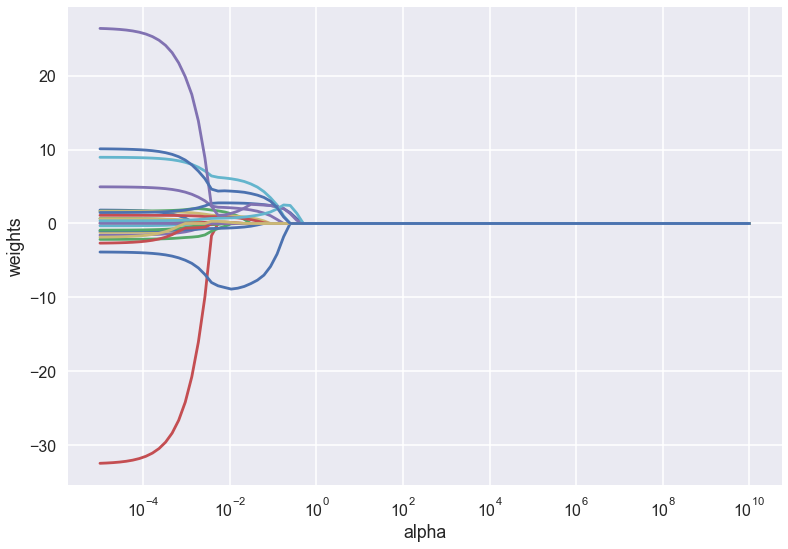

In [62]:
lasso = Lasso(max_iter=10000, normalize=True)
alphas = 10**np.linspace(10, -5, 100) * 0.5

coeffs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(quant.drop('W', axis=1)), quant['W'])
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas * 2, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

plt.show()

In [69]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(scale(quant.drop('W', axis=1)), quant['W'])

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(quant.drop('W', axis=1)), quant['W'])
mseLasso = mean_squared_error(quant['W'], lasso.predict(scale(quant.drop('W', axis=1))))
print(pd.Series(lasso.coef_, index=quant.drop('W', axis=1).columns))
print('Lasso Test MSE: ' + str(mseLasso))

G              1.280764
Ghome          1.762190
AB           -28.329085
doubles        4.601553
triples        1.581303
HR             8.616410
BB             1.638444
SO             0.501548
SB             1.086379
CS            -1.352620
HBP            0.563691
SF            -0.933631
RA            -4.410559
ER            -2.023143
CG             0.066586
IPouts        23.087432
HA            -0.995454
HRA           -0.218433
BBA           -0.917258
SOA           -0.727047
E             -1.505040
DP             0.000000
FP            -0.785305
attendance     0.404600
singles        9.344139
dtype: float64
Lasso Test MSE: 15.1676375686
